In [54]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

### 기본 그래프 생성

LangGraph의 그래프 정의하기

1. State 정의
2. 노드 정의
3. 그래프 정의
4. 그래프 컴파일
5. 그래프 시작화

단계를 거칩니다.

### State 정의

`State`: Graph 의 노드와 노드들을 끼리 공유하는 상태를 정의합니다.

In [55]:
from typing import Annotated, List, TypedDict
from langchain_core.documents import Document
import operator

class GraphState(TypedDict):
    context: Annotated[List[Document], operator.add]        # 문서의 검색 결과
    answer: Annotated[List[Document], operator.add]         # 답변
    question: Annotated[str, 'user question']               # 질문
    sql_query: Annotated[str, 'sql query']                  
    binary_score: Annotated[str, 'binary score yes or no']

### 노드 정의

`Nodes`: 각 단계를 처리하는 노드입니다. Python 함수로 만들게 되고 함수의 입력과 출력이 상태(State) 값입니다. <br>

`State` 를 입력으로 받아 정의된 로직을 수행한 후 업데이트된 State를 반환합니다.

In [56]:
def retrieve(state: GraphState) -> GraphState:          # 문서 검색 노드
    # retrieve: 검색
    
    documents = '검색된 문서'
    return {'context': documents}

In [57]:
def llm_gpt_execute(state: GraphState) -> GraphState:   # 답변 생성 노드
    # LLM 실행

    answer = 'GPT에서 생성된 답변'
    return GraphState(answer=answer)

In [58]:
def relevance_check(state: GraphState) -> GraphState:   # 관련성 체크 노드
    # Relevance Check: 관련성 확인

    binary_score = 'yes'
    return GraphState(binary_score=binary_score)

In [59]:
def sum_up(state: GraphState) -> GraphState:
    # sum_up: 결과 종합

    answer = '종합된 답변'
    return GraphState(answer=answer)

### 그래프 정의

`Edges`: 현재 State를 기반으로 다음에 실행할 Node를 결정하는 Python 함수.<br>

일반 엣지, 조건부 엣지 등이 있습니다.

In [60]:
from langgraph.checkpoint.memory import MemorySaver
from langchain_teddynote.graphs import visualize_graph
from langgraph.graph import StateGraph, END

In [61]:
######### 1. 그래프 생성 #########

workflow = StateGraph(GraphState)

In [62]:
######### 2. 노드 정의  #########

# 노드 이름, 함수 이름을 넣으서 노트를 추가
workflow.add_node('retrieve', retrieve)
workflow.add_node('GPT 요청', llm_gpt_execute)
workflow.add_node('GPT_relevance_ckeck', relevance_check)
workflow.add_node('결과 종합', sum_up)

In [63]:
######### 3. 그래프 엣지(Edge) 추가  #########

workflow.add_edge('retrieve', 'GPT 요청')
workflow.add_edge('GPT 요청', 'GPT_relevance_ckeck')
workflow.add_edge('GPT_relevance_ckeck', '결과 종합')
workflow.add_edge('결과 종합', END)

In [64]:
######### 4. 그래프 진입점  #########

workflow.set_entry_point('retrieve')

In [65]:
######### 5. 체크 포인터 설정  #########

memory = MemorySaver()

In [66]:
######### 6. 그래프 컴파일(compile)  #########

app = workflow.compile(checkpointer=memory)

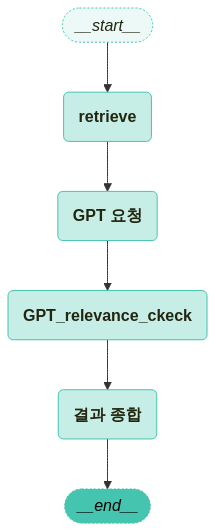

In [67]:
visualize_graph(app)

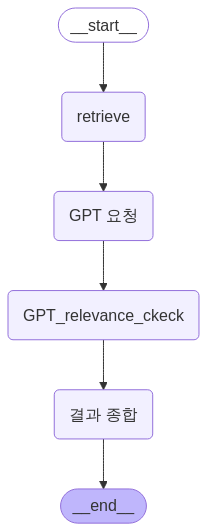

In [68]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))